In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from skfuzzy.cluster import cmeans
from scipy.spatial.distance import pdist, squareform

In [2]:
# has 52608 rows
df_full = pd.read_csv('dataset_2019_2025.csv')

# has 1880 rows
df_no_na = df_full.dropna().drop(columns=['datetime'])

# fully numerical dataset with no missing values
df_no_na

,precipitation,cloud_cover,sunshine,temperature,relative_humidity,price,nuclear,hydro_run_of_river,biomass,fossil_brown_coal_/_lignite,...,czech_republic_cbet,denmark_cbet,france_cbet,luxembourg_cbet,netherlands_cbet,norway_cbet,poland_cbet,sweden_cbet,switzerland_cbet,sum_cbet
35066,0.00,96.75,0.00,14.200,56.00,-5.08,2461.1,1611.8,3984.3,3823.1,...,-0.778,-2.546,-3.407,-0.298,0.032,-1.309,-0.825,-0.519,-0.642,-14.542
35067,0.00,93.75,0.00,13.800,58.50,-4.49,2464.7,1607.0,4004.1,3825.6,...,-0.402,-2.677,-4.739,-0.305,0.173,-1.318,-0.373,-0.519,-0.789,-13.618
35068,0.00,87.50,0.00,13.650,59.50,-5.40,2464.2,1604.2,4050.8,3773.7,...,-0.604,-2.573,-4.272,-0.292,0.182,-1.376,-0.539,-0.519,-0.595,-13.729
35069,0.00,81.25,0.00,13.750,58.50,-5.02,2464.7,1595.0,4084.9,3818.9,...,-0.423,-2.625,-5.594,-0.305,-0.102,-1.396,-0.604,-0.519,-0.796,-14.815
35070,0.00,71.75,0.00,13.875,57.50,-1.30,2463.6,1590.8,4137.3,3788.4,...,-0.293,-2.412,-4.619,-0.320,0.129,-1.376,-0.459,-0.519,-0.772,-12.869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37575,0.15,96.75,0.25,9.950,78.50,98.81,2502.4,1810.5,4556.2,9874.6,...,-0.604,2.265,1.425,-0.349,1.315,0.900,-0.395,0.615,-0.796,4.024
37576,0.05,100.00,0.00,9.625,79.50,112.66,2511.3,1813.0,4705.6,10301.0,...,-0.354,2.342,0.352,-0.370,0.621,1.070,-0.543,0.615,-0.800,2.697
37577,0.05,100.00,0.00,9.150,82.25,132.79,2148.9,1818.1,4747.8,10378.1,...,-0.750,2.220,-0.870,-0.375,0.054,1.260,-0.247,0.615,-0.782,1.116
37578,0.15,96.75,0.00,8.525,86.75,134.51,1696.5,1819.0,4691.6,10438.5,...,-0.465,2.408,-0.609,-0.354,0.111,1.250,-0.433,0.615,-0.800,1.321


In [3]:
# wide range of standard deviations so i'm going to scale
df_no_na.describe()

,precipitation,cloud_cover,sunshine,temperature,relative_humidity,price,nuclear,hydro_run_of_river,biomass,fossil_brown_coal_/_lignite,...,czech_republic_cbet,denmark_cbet,france_cbet,luxembourg_cbet,netherlands_cbet,norway_cbet,poland_cbet,sweden_cbet,switzerland_cbet,sum_cbet
count,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,...,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000
mean,0.084722,81.686905,9.856746,5.861997,75.964947,117.328524,2672.056561,1642.051905,4562.319630,10717.695132,...,-0.269847,1.246131,-1.638412,-0.458102,-0.160902,0.402004,-0.243149,0.331195,-0.778712,-3.361246
std,0.180620,22.064730,14.836526,4.222302,11.263492,48.890945,310.877948,169.471402,208.437785,3636.598101,...,0.846208,1.486925,2.511473,0.090418,1.180025,0.923021,0.740756,0.343859,0.699841,5.235263
min,0.000000,0.000000,0.000000,-4.800000,36.750000,-8.820000,1539.200000,1303.400000,3984.300000,3765.800000,...,-2.135000,-3.442000,-8.591000,-0.674000,-4.047000,-1.400000,-1.917000,-0.615000,-2.000000,-19.227000
25%,0.000000,71.750000,0.000000,2.531250,70.500000,92.285000,2411.675000,1520.400000,4403.375000,7691.600000,...,-0.977750,0.580250,-3.661000,-0.521750,-1.012000,-0.138000,-0.805750,0.000000,-1.138750,-7.112500
50%,0.000000,90.500000,0.250000,5.875000,78.500000,118.215000,2791.950000,1612.600000,4564.650000,11350.800000,...,-0.284500,1.701000,-1.709000,-0.463000,-0.174000,0.685000,-0.413000,0.548500,-0.800000,-3.145500
75%,0.075000,96.750000,15.250000,8.925000,84.000000,149.957500,2942.325000,1749.375000,4726.375000,13833.725000,...,0.302000,2.300000,0.171250,-0.393000,0.603000,1.220000,0.203750,0.615000,-0.710000,0.623000
max,2.025000,100.000000,60.000000,16.925000,96.000000,270.220000,3076.200000,2299.100000,5011.700000,16486.100000,...,2.615000,3.444000,5.951000,-0.224000,3.694000,1.401000,2.224000,0.615000,3.190000,10.452000


In [4]:
scaled_df_array = StandardScaler().fit_transform(df_no_na)
X = pd.DataFrame(scaled_df_array, columns=df_no_na.columns)
X

,precipitation,cloud_cover,sunshine,temperature,relative_humidity,price,nuclear,hydro_run_of_river,biomass,fossil_brown_coal_/_lignite,...,czech_republic_cbet,denmark_cbet,france_cbet,luxembourg_cbet,netherlands_cbet,norway_cbet,poland_cbet,sweden_cbet,switzerland_cbet,sum_cbet
0,-0.469188,0.682858,-0.664533,1.975276,-1.773005,-2.504368,-0.678763,-0.178555,-2.773838,-1.896393,...,-0.600665,-2.550992,-0.704390,1.771154,0.163516,-1.854190,-0.785691,-2.473167,0.195399,-2.136228
1,-0.469188,0.546859,-0.664533,1.880515,-1.550990,-2.492297,-0.667180,-0.206886,-2.678820,-1.895706,...,-0.156212,-2.639116,-1.234896,1.693715,0.283037,-1.863943,-0.175342,-2.473167,-0.014705,-1.959685
2,-0.469188,0.263526,-0.664533,1.844980,-1.462185,-2.510915,-0.668788,-0.223412,-2.454713,-1.909981,...,-0.394987,-2.569155,-1.048900,1.837530,0.290666,-1.926797,-0.399497,-2.473167,0.262574,-1.980893
3,-0.469188,-0.019806,-0.664533,1.868670,-1.550990,-2.503141,-0.667180,-0.277713,-2.291072,-1.897548,...,-0.181035,-2.604136,-1.575424,1.693715,0.049929,-1.948471,-0.487268,-2.473167,-0.024710,-2.188388
4,-0.469188,-0.450472,-0.664533,1.898283,-1.639796,-2.427033,-0.670719,-0.302502,-2.039612,-1.905938,...,-0.027368,-2.460849,-1.187103,1.527776,0.245740,-1.926797,-0.291470,-2.473167,0.009593,-1.816579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,0.361506,0.682858,-0.647678,0.968449,0.225128,-0.378872,-0.545878,0.994225,-0.029367,-0.231898,...,-0.394987,0.685400,1.220089,1.206959,1.251069,0.539671,-0.205049,0.825573,-0.024710,1.411047
1886,-0.192290,0.830191,-0.664533,0.891457,0.313934,-0.095514,-0.517242,1.008980,0.687583,-0.114614,...,-0.099473,0.737198,0.792737,0.974643,0.662790,0.723898,-0.404898,0.825573,-0.030427,1.157506
1887,-0.192290,0.830191,-0.664533,0.778929,0.558150,0.316328,-1.683281,1.039082,0.890095,-0.093407,...,-0.567567,0.655128,0.306041,0.919330,0.182165,0.929798,-0.005201,0.825573,-0.004700,0.855436
1888,0.361506,0.682858,-0.664533,0.630866,0.957776,0.351518,-3.138900,1.044394,0.620399,-0.076794,...,-0.230682,0.781597,0.409992,1.151645,0.230482,0.918961,-0.256362,0.825573,-0.030427,0.894604


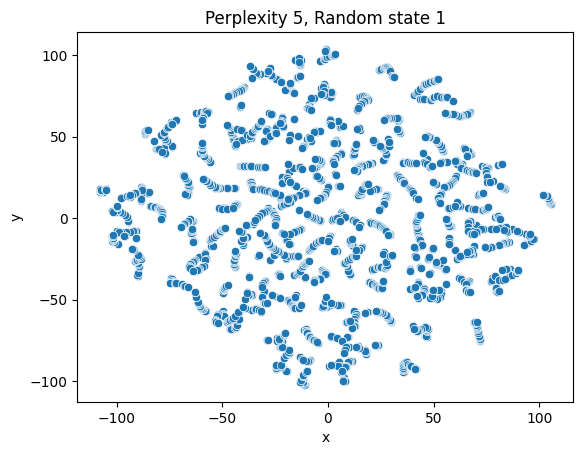

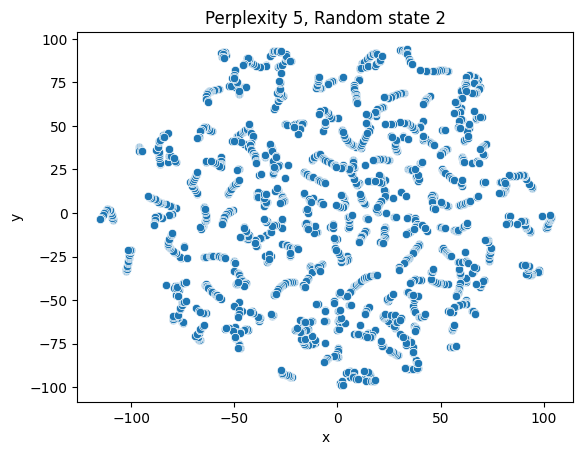

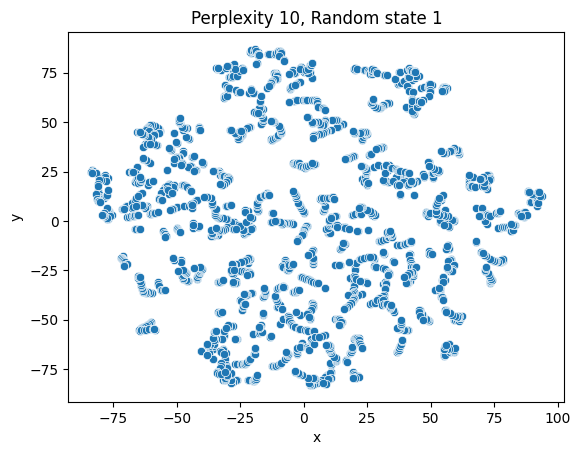

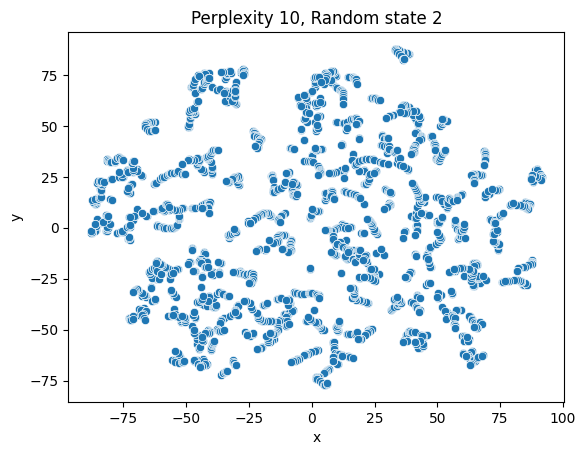

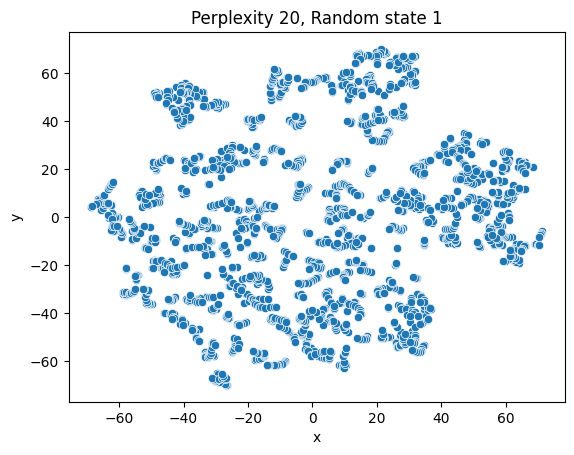

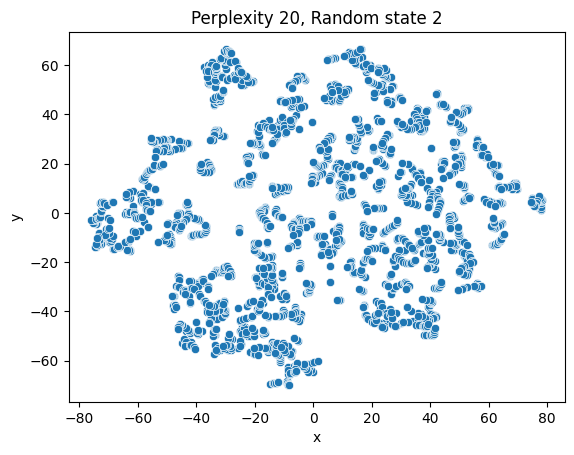

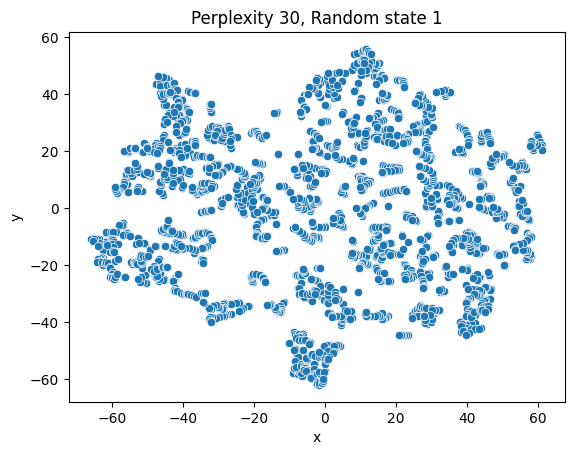

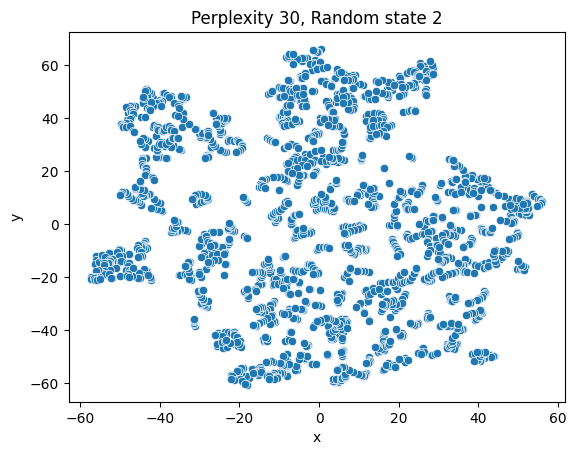

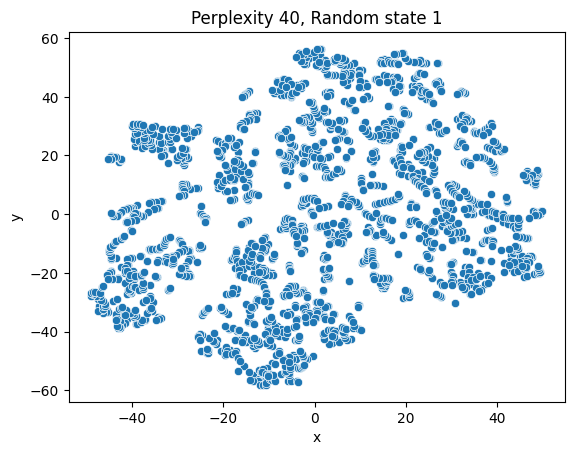

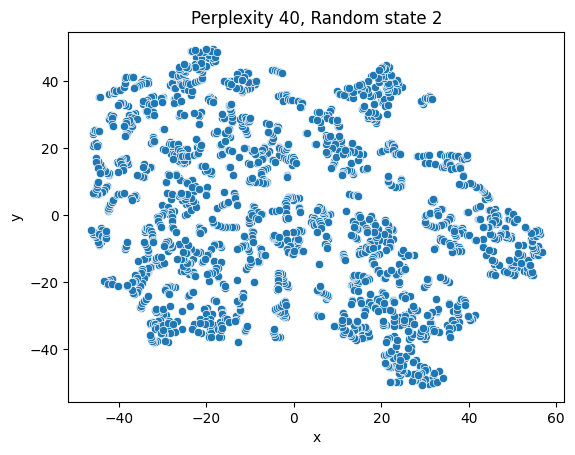

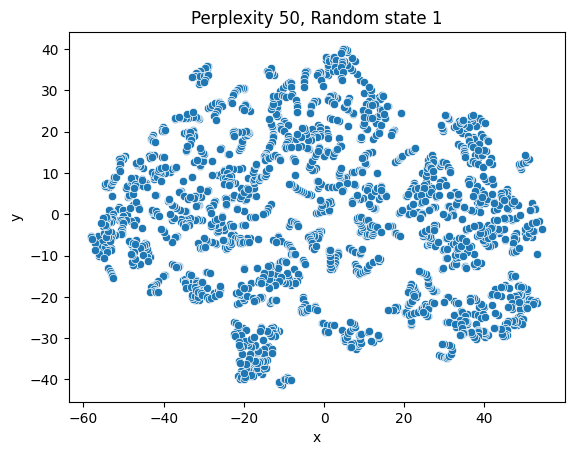

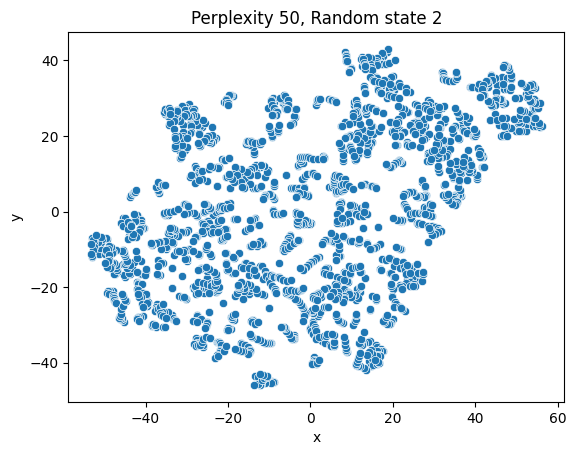

In [5]:
for perp in [5, 10, 20, 30, 40, 50]:
    tsne_rand1 = TSNE(n_components=2, perplexity = perp, init='random', random_state=1)
    tsne_rand2 = TSNE(n_components=2, perplexity = perp, init='random', random_state=2)

    data_tsne1 = tsne_rand1.fit_transform(X)
    data_tsne2 = tsne_rand2.fit_transform(X)

    df_tsne1 = pd.DataFrame(data_tsne1, columns=['x', 'y'])
    df_tsne2 = pd.DataFrame(data_tsne2, columns=['x', 'y'])

    sns.scatterplot(x='x', y='y', data=df_tsne1).set_title(f'Perplexity {perp}, Random state 1')
    plt.show()
    sns.scatterplot(x='x', y='y', data=df_tsne2).set_title(f'Perplexity {perp}, Random state 2')
    plt.show()